<a href="https://colab.research.google.com/github/eshmaapps/ml/blob/main/Regression_advtech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

               
The problem is to predict housing prices (houses) based on their characteristics. This is a regression problem because we try to predict a continuous value instead of a binary value.



# Contents
1. [Importing Packages](#p1)
2. [Loading Data](#p2)
3. [Inspecting Data: Target Variable and its correlation](#p3)
4. [Imputing Null Values](#p4)
5. [Feature Engineering](#p5)
6. [ML Models](#p6)
7. [Model Comparison](#p7)
8. [Parameter tuning for Gradient Boosting](#p8)
9. [Blending + Submission](#p9)

<a id="p1"></a>
# 1.  Importing Packages
We will need as usual the numpy and pandas libraries to work with numbers and data, seaborn and matplotlib to visualize data. We would also like to filter out unnecessary warnings.

In [1]:
! pip3 install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

<a id="p2"></a>
# 2. Loading and Inspecting Data
We will try to load our Training and Test data set with some Pandas functions as well as inspect it in order to get an idea of the data we're working with. It is necessary to understand the data features before to start running any model.

In [2]:
import torch
torch.cuda.is_available()


True

In [26]:
#Data_train
df_train = pd.read_csv('train.csv')
#Data_test
df_test = pd.read_csv('test.csv')
df_train = df_train.drop(["Last Sold On", "Address", "Id", "Summary", "Region", "Elementary School", "Middle School", "Elementary School Distance","Middle School Distance", "High School", "High School Distance"], axis=1)
df_test = df_test.drop(["Last Sold On", "Address", "Id", "Summary", "Region", "Elementary School", "Middle School", "Elementary School Distance","Middle School Distance", "High School", "High School Distance"], axis=1)

In [ ]:
device = torch.device('cuda')
df_train.to(device, non_blocking=True)

In [ ]:
df_train.shape, df_test.shape

In [ ]:
df_train.describe()

In [ ]:
df_train.keys()

<a id="p3"></a>
# 3. Inspecting Data: Target Variable and its Correlation


In [ ]:
#histogram
df_train['Sold Price'].hist(bins = 3)

In [ ]:
(np.log(df_train["Sold Price"])).hist(bins = 40)


We can clearly see that the target variable has a normal ditribution that is skewed towards the left. Now let's calculate the Skewness and Kurtosis :

In [ ]:
#skewness & kurtosis
print("Skewness: %f" % df_train['Sold Price'].skew())
print("Kurtosis: %f" % df_train['Sold Price'].kurt())

Skewness: 12.513866
Kurtosis: 325.084888


As we've seen before, there are so many columns to work with, so let's try to figure out the correlations to get a better idea of which columns are strongly related to the Sale Price of the house. This will help us eliminating the features that won't do a good job predicting the Sale Price.

In [ ]:
#correlation matrix
corrmat = df_train.corr()
#Plot a heatmap to visualize the correlations
f, ax = plt.subplots(figsize=(30, 19))
sns.set(font_scale=1.45)
sns.heatmap(corrmat, square=True,cmap='coolwarm');
correlations = corrmat["Sold Price"].sort_values(ascending=False)
features = correlations.index[0:15]
features

In [ ]:
corrmat = df_train.corr()

correlations = corrmat["Price"].sort_values(ascending=False)
features = correlations.index[0:15]
features

In [ ]:
#sns.pairplot(df_train[features], size = 2.5)
#plt.show();

<a id="p4"></a>
# 4. Imputing Null Values


First of all, we will start with dropping the Id column , as it doesn't add any information for our model.

In this large data, we have a lot of missing values in the cells. In order to effectively train our model, we must first deal with the missing values. There are missing values for both numerical and categorical data.

For numerical imputing, we will try to fill the missing values with the mean. For categorical imputing, I chose to fill the missing values with the most common term that appeared from the entire column.

## NaN values are important
In fact, the NaN values actually mean something in some columns. This means that if a value is NaN, the house might not have that certain attribute, which will affect the price of the house.
So, we will try to fill in the null cell with a new category called "None".

In [27]:
#Replacing every Nan value with "None"
null_with_meaning = [ "Heating", "Cooling", "Heating features", "Cooling features", "Garage spaces","Parking","Parking features", "Appliances included", "Laundry features"]
for i in null_with_meaning:
    df_train[i].fillna("None", inplace=True)
    df_test[i].fillna("None", inplace=True)

# missing Full bathrooms, Total interior livable area, Total spaces, Elementary School Score,  
#Middle School Score, High School Score, Flooring,
meanVals = [ "Lot", "Year built", "Total interior livable area", "Total spaces", "Elementary School Score", "Middle School Score", "High School Score" ]
for i in meanVals:
    df_train[i].fillna(df_train[i].mean(), inplace=True)
    df_test[i].fillna(df_test[i].mean(), inplace=True)
    

df_train["Flooring"].fillna("Carpet", inplace=True)
df_test["Flooring"].fillna("Carpet", inplace=True)

In [46]:
beds = df_train["Bedrooms"]
testbeds = df_test["Bedrooms"]



In [61]:
baths = df_train["Bathrooms"]
testbaths = df_test["Bathrooms"]

In [62]:
def fixParam(x):
    index = 0
    for i in x:
      #if len(i) >2:
       # print(i)
        #x.at[index] = '3.0'
      if str(i) == 'nan':
        x.at[index] = '2.0'
      index = index + 1
    return x

baths = fixParam(baths)
testbaths = fixParam(testbaths)



In [63]:
print(baths.nunique())
baths = baths.astype(float)
df_train["Bathrooms"] = baths

23


In [60]:
print(beds.nunique())
print(testbeds.nunique())
beds = beds.astype(float)
df_train["Bedrooms"] = beds
testbeds = testbeds.astype(float)
df_test["Bedrooms"] = testbeds

31
21


In [38]:


print(testbaths.nunique())
testbaths = testbaths.astype(float)
df_test["Full bathrooms"] = testbaths

17
15


In [39]:
df_train["Full bathrooms"] = baths


In [42]:
df_train = df_train.drop(['Full bthrooms'], axis=1)

In [44]:
df_train.columns

Index(['Sold Price', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
       'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Middle School Score', 'High School Score',
       'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Laundry features', 'Parking features',
       'Tax assessed value', 'Annual tax amount', 'Listed On', 'Listed Price',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [ ]:
setToValue = ["Bedrooms","Full bathrooms", "Bathrooms"]
#setToValue = ["Bathrooms"]
for i in setToValue:
    df_train = fixParam(i, df_train)
    df_test = fixParam(i, df_test)

In [64]:
df_train.describe()
training_null = pd.isnull(df_train).sum()
testing_null = pd.isnull(df_test).sum()

print(training_null)

Sold Price                         0
Type                               0
Year built                         0
Heating                            0
Cooling                            0
Parking                            0
Lot                                0
Bedrooms                           0
Bathrooms                          0
Full bathrooms                     0
Total interior livable area        0
Total spaces                       0
Garage spaces                      0
Elementary School Score            0
Middle School Score                0
High School Score                  0
Flooring                           0
Heating features                   0
Cooling features                   0
Appliances included                0
Laundry features                   0
Parking features                   0
Tax assessed value              3652
Annual tax amount               4310
Listed On                          0
Listed Price                       0
Last Sold Price                17766
C

In [65]:
def lookup(basedOn1, basedOn2, x):
    y = x.groupby(basedOn1)[basedOn2].apply(lambda x: x.replace(np.nan, x.value_counts().mean()))
    #print(x[basedOn1], y) #= x = x.sort_values('col1')
    x[basedOn2] = y
    return x
lookupVals = ["Tax assessed value", "Annual tax amount", "Last Sold Price"]
for i in lookupVals:
    df_train = lookup("Zip", i,  df_train)
    df_test = lookup("Zip", i, df_test)

In [66]:
df_train.describe()
training_null = pd.isnull(df_train).sum()
testing_null = pd.isnull(df_test).sum()

print(training_null)

Sold Price                       0
Type                             0
Year built                       0
Heating                          0
Cooling                          0
Parking                          0
Lot                              0
Bedrooms                         0
Bathrooms                        0
Full bathrooms                   0
Total interior livable area      0
Total spaces                     0
Garage spaces                    0
Elementary School Score          0
Middle School Score              0
High School Score                0
Flooring                         0
Heating features                 0
Cooling features                 0
Appliances included              0
Laundry features                 0
Parking features                 0
Tax assessed value              43
Annual tax amount               71
Listed On                        0
Listed Price                     0
Last Sold Price                167
City                             0
Zip                 

In [ ]:
print(pd.isnull(df_train["Tax assessed value"])==1, df_train.index)

In [67]:
#for i in range(len(df_train["Tax assessed value"])):
 #   if pd.isnull(df_train["Tax assessed value"][i]):
       # print(i, df_train["Zip"][i])

#for i in range(len(df_train["Zip"])):
 #   if (df_train["Zip"][i] == 95595):
  #      print(i, df_train["Tax assessed value"][i])
        
lookupVals = ["Tax assessed value", "Annual tax amount", "Last Sold Price"]
for i in lookupVals:
    df_train[i].fillna(df_train[i].mean(), inplace=True)
    df_test[i].fillna(df_test[i].mean(), inplace=True)

In [69]:
df_train.to_pickle("unencodedTrainingSet.pkl")
df_test.to_pickle("unencodedTestSet.pkl")

In [70]:
df_train.columns

Index(['Sold Price', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking',
       'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Middle School Score', 'High School Score',
       'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Laundry features', 'Parking features',
       'Tax assessed value', 'Annual tax amount', 'Listed On', 'Listed Price',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [71]:
df_test.columns

Index(['Type', 'Year built', 'Heating', 'Cooling', 'Parking', 'Lot',
       'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Middle School Score', 'High School Score',
       'Flooring', 'Heating features', 'Cooling features',
       'Appliances included', 'Laundry features', 'Parking features',
       'Tax assessed value', 'Annual tax amount', 'Listed On', 'Listed Price',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [73]:
df_train.shape

(47439, 30)

In [74]:
df_test.shape

(31626, 29)

In [ ]:
df_train = pd.read_pickle("my_data.pkl")

Now, the features with a lot of missing values have been taken care of! Let's move on to the features with fewer missing values.

In [75]:
def encode(x):
    # "Cardinality" means the number of unique values in a column
    # Select categorical columns with relatively low cardinality (convenient but arbitrary)
    object_cols = [col for col in x.columns if x[col].dtype == "object"]

    low_cardinality_cols = [cname for cname in x.columns if x[cname].nunique() < 100 and 
                            x[cname].dtype == "object"]
    # Columns that will be dropped from the dataset
    high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

    print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
    print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

    from sklearn.preprocessing import OneHotEncoder
    print (x.dtypes())
    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(x[low_cardinality_cols]))

    # One-hot encoding removed index; put it back
    OH_cols.index = x.index

    # Remove categorical columns (will replace with one-hot encoding)
    num_X = x.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    OH_X = pd.concat([num_X, OH_cols], axis=1)
    return OH_X

df_train = encode(df_train)
df_test = encode(df_test)

Categorical columns that will be one-hot encoded: ['Garage spaces', 'State']

Categorical columns that will be dropped from the dataset: ['Type', 'Parking', 'Cooling', 'Cooling features', 'Parking features', 'Laundry features', 'Flooring', 'Heating', 'Listed On', 'Appliances included', 'Heating features', 'City']


TypeError: ignored

In [28]:
df_test.columns

Index([                 'Year built',                         'Lot',
                         'Bathrooms',              'Full bathrooms',
       'Total interior livable area',                'Total spaces',
           'Elementary School Score',         'Middle School Score',
                 'High School Score',          'Tax assessed value',
                 'Annual tax amount',                'Listed Price',
                   'Last Sold Price',                         'Zip',
                                   0,                             1],
      dtype='object')

In [ ]:
for i in df_train["Heating"]:
  if i == "None":
    print (i)
    df_train["Heating"] = "0.0"
  if i == "In Garage":
    df_train["Heating"] = "1.0"
  if i == "In Garage":
    

In [29]:
df_train = df_train.drop([0, 1 ], axis = 1)
df_test = df_test.drop([0, 1 ] , axis = 1)

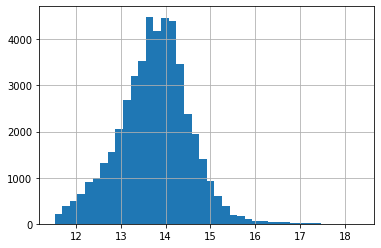

In [30]:
(np.log(df_train["Sold Price"])).hist(bins = 40)
#It appears that adding the logarithm has made the target SalePrice more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets. By transforming the prices, we can improve the performance later.
y_train = np.log(df_train["Sold Price"])
df_train = df_train.drop(['Sold Price'], axis=1)

<a id="p6"></a>
# 6. Process : ML Models
Now that we've explored the data, we can begin to build and test different models for regression to predict the SalePrice of each house.
In classification, we used accuracy as a evaluation metric. In regression, we will use the R^2 score as well as the RMSE to evaluate our model performance. We will also use cross validation to optimize our model hyperparameters.

In [31]:
#Importing all the librairies we'll need

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

### Defining Training/Test Sets

We have already dropped the Id column for the training set since those are not involved in predicting the Sale Price of a house. We will also drop The SalePrice column from our training dataset and make LogPrice our target instead. This will improve model performance and yield a much smaller RMSE because of the scale.

### Splitting into Validation

Try to split our training data again into validation sets. This will help us evaluate our model performance and maybe avoid overfitting.

In [34]:
from sklearn.model_selection import train_test_split #to create validation data set

X_training, X_valid, y_training, y_valid = train_test_split(df_train, y_train, test_size=0.2, random_state=0) #X_valid and y_valid are the validation sets

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_training,y_training)
print(lm)

**Model Evaluation**
Let's evaluate the model by checking out it's coefficients and how we can interpret them.

In [ ]:
# print the intercept
print(lm.intercept_)

In [ ]:
print(lm.coef_)

**Predictions from our Model** 

In [ ]:
predictions = lm.predict(X_valid)
predictions= predictions.reshape(-1,1)

In [ ]:
submission_predictions = np.exp(predictions)

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_valid, submission_predictions))
print('MSE:', metrics.mean_squared_error(y_valid, submission_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, submission_predictions)))

**Adding the GridSearchCV function**

In [ ]:
linreg = LinearRegression()
parameters_lin = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg = GridSearchCV(linreg, parameters_lin, verbose=1 , scoring = "r2")
grid_linreg.fit(X_training, y_training)

print("Best LinReg Model: " + str(grid_linreg.best_estimator_))
print("Best Score: " + str(grid_linreg.best_score_))

In [ ]:
linreg = grid_linreg.best_estimator_
linreg.fit(X_training, y_training)
lin_pred = linreg.predict(X_valid)
r2_lin = r2_score(y_valid, lin_pred)
rmse_lin = np.sqrt(mean_squared_error(y_valid, lin_pred))
print("R^2 Score: " + str(r2_lin))
print("RMSE Score: " + str(rmse_lin))

In [ ]:
scores_lin = cross_val_score(linreg, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_lin)))

## Ridge Model

In [ ]:
ridge = Ridge()
parameters_ridge = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False], "solver" : ["auto"]}
grid_ridge = GridSearchCV(ridge, parameters_ridge, verbose=1, scoring="r2")
grid_ridge.fit(X_training, y_training)

print("Best Ridge Model: " + str(grid_ridge.best_estimator_))
print("Best Score: " + str(grid_ridge.best_score_))

In [ ]:
ridge = grid_ridge.best_estimator_
ridge.fit(X_training, y_training)
ridge_pred = ridge.predict(X_valid)
r2_ridge = r2_score(y_valid, ridge_pred)
rmse_ridge = np.sqrt(mean_squared_error(y_valid, ridge_pred))
print("R^2 Score: " + str(r2_ridge))
print("RMSE Score: " + str(rmse_ridge))

In [ ]:
scores_ridge = cross_val_score(ridge, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_ridge)))

## Gradient Boosting Regression

In [32]:
from sklearn import ensemble

In [35]:
params = {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls' }
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_training, y_training)

GradientBoostingRegressor(learning_rate=0.05, loss='ls', max_depth=5,
                          n_estimators=200)

In [36]:
clf_pred=clf.predict(X_valid)
clf_pred= clf_pred.reshape(-1,1)
r2_clf = r2_score(y_valid, clf_pred)
rmse_clf = np.sqrt(mean_squared_error(y_valid, clf_pred))
print("R^2 Score: " + str(r2_clf))
print("RMSE Score: " + str(rmse_clf))

R^2 Score: 0.9368220402156536
RMSE Score: 0.19962770369880276


In [37]:
scores_clf = cross_val_score(clf, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_clf)))

Cross Validation Score: 0.9333775275436238


## Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state = 100)
parameters_dtr = {"criterion" : ["mse", "friedman_mse", "mae"], "splitter" : ["best", "random"], "min_samples_split" : [2, 3, 5, 10], 
                  "max_features" : ["auto", "log2"]}
grid_dtr = GridSearchCV(dtreg, parameters_dtr, verbose=1, scoring="r2")
grid_dtr.fit(X_training, y_training)

print("Best DecisionTreeRegressor Model: " + str(grid_dtr.best_estimator_))
print("Best Score: " + str(grid_dtr.best_score_))

In [ ]:
dtr = grid_dtr.best_estimator_
dtreg.fit(X_training, y_training)
dtr_pred = dtreg.predict(X_valid)
r2_dtr = r2_score(y_valid, dtr_pred)
rmse_dtr = np.sqrt(mean_squared_error(y_valid, dtr_pred))
print("R^2 Score: " + str(r2_dtr))
print("RMSE Score: " + str(rmse_dtr))

In [ ]:
scores_dtr = cross_val_score(dtreg, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_dtr)))

## Random Forest Regression 

In [ ]:
rfr = RandomForestRegressor()
paremeters_rf = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
                 "max_features" : ["auto", "log2"]}
grid_rf = GridSearchCV(rfr, paremeters_rf, verbose=1, scoring="r2")
grid_rf.fit(X_training, y_training)

print("Best RandomForestRegressor Model: " + str(grid_rf.best_estimator_))
print("Best Score: " + str(grid_rf.best_score_))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [ ]:
rf = grid_rf.best_estimator_
rfr.fit(X_training, y_training)
rf_pred = rfr.predict(X_valid)
r2_rf = r2_score(y_valid, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_valid, rf_pred))
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))

In [ ]:
scores_rf = cross_val_score(rfr, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_rf)))

In [ ]:
import sys

!{sys.executable} -m pip install xgboost

  Using cached xgboost-1.6.2-py3-none-macosx_12_0_arm64.whl (1.5 MB)


## Xgboost

In [38]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=20000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.006)
xgb = xgboost.fit(X_training, y_training)
xgb_pred = xgb.predict(X_valid)
r2_xgb = r2_score(y_valid, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, xgb_pred))
print("R^2 Score: " + str(r2_xgb))
print("RMSE Score: " + str(rmse_xgb))

R^2 Score: 0.9376785368879113
RMSE Score: 0.19826992072359856


In [ ]:
xgboost.save('myHousingAdvModelxgb')
clf.save('myHousingAdvModelgb')
rfr.save('myHousingAdvModelRf')

In [ ]:
!pip install lightgbm

### LGBM Regressor

In [ ]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=20000,
                                       max_bin=2000, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
gbm = lightgbm.fit(X_training, y_training)

In [ ]:
gbm_pred = gbm.predict(X_valid)
r2_gbm = r2_score(y_valid, gbm_pred)
rmse_gbm = np.sqrt(mean_squared_error(y_valid, gbm_pred))
print("R^2 Score: " + str(r2_gbm))
print("RMSE Score: " + str(rmse_gbm))


In [ ]:
rmse_gbm = 0.0
r2_gbm = 0.0

<a id="p7"></a>
# 7. Model Comparison
After applying different models and evaluating them, now we will use test data to predict the LogPrice with the most adequat one.

In [ ]:
model_performances = pd.DataFrame({
    "Model" : ["Linear Regression", "Ridge", "Decision Tree Regressor", "Random Forest Regressor","Gradient Boosting Regression","XGBoost","LGBM Regressor"],
    "R Squared" : [str(r2_lin)[0:5], str(r2_ridge)[0:5],  str(r2_dtr)[0:5], str(r2_rf)[0:5] , str(r2_clf)[0:5], str(r2_xgb)[0:5], str(r2_gbm)[0:5]],
    "RMSE" : [str(rmse_lin)[0:8], str(rmse_ridge)[0:8],  str(rmse_dtr)[0:8], str(rmse_rf)[0:8], str(rmse_clf)[0:8], str(rmse_xgb)[0:8], str(rmse_gbm)[0:8]]
})
model_performances.round(4)

print("Sorted by R Squared:")
model_performances.sort_values(by="R Squared", ascending=False)

In [ ]:
print("Sorted by RMSE:")
model_performances.sort_values(by="RMSE", ascending=True)

Finally, I decided to use the XGBoost on the test set because I believe it will perform the best based on the comparison above. It has a high R^2 value and a low RMSE.
But before doing that, let's try to improve our Gradient Boosting Regression model by tuning its parameters.

<a id="p8"></a>
# 8. Parameter tuning for Gradient Boosting

## Learning_rate

In [ ]:
learning_rates = [0.75 ,0.5, 0.25, 0.1, 0.05, 0.01]

r2_results = []
rmse_results = []

for eta in learning_rates:
    model = ensemble.GradientBoostingRegressor(learning_rate=eta)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, r2_results, 'b', label='R^2')
line2, = plt.plot(learning_rates, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('learning_rates')
plt.show()


We see that using a high learning rate results in overfitting. For this data, a learning rate of 0.05 is optimal.

## N_estimators
N_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data.

In [ ]:
n_estimators = [1, 2, 16, 32, 64, 100, 200, 500]
r2_results = []
rmse_results = []

for estimator in n_estimators:
    model = ensemble.GradientBoostingRegressor(n_estimators=estimator)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, r2_results, 'b', label='R^2')
line2, = plt.plot(n_estimators, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('n_estimators')
plt.show()

In our case, using more than 100 trees is good for our model.

## Max_depth
This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. 

In [ ]:
max_depths = np.linspace(1, 10, 10, endpoint=True)
r2_results = []
rmse_results = []

for max_depth in max_depths:
    max_depth = int(max_depth)
    model = ensemble.GradientBoostingRegressor(max_depth=max_depth)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, r2_results, 'b', label='R^2')
line2, = plt.plot(max_depths, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('max_depths')
plt.show()


Based on the plots above, we will choose a max_depth = 5.

## Min_samples_split
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node.

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
r2_results = []
rmse_results = []

for min_samples_split in min_samples_splits:
    model = ensemble.GradientBoostingRegressor(min_samples_split=min_samples_split)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, r2_results, 'b', label='R^2')
line2, = plt.plot(min_samples_splits, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('min_samples_splits')
plt.show()

So we will choose min_samples_splits = 0.28

## Min_samples_leaf
The minimum number of samples required to be at a leaf node. 

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
r2_results = []
rmse_results = []

for min_samples_leaf in min_samples_leafs:
    model = ensemble.GradientBoostingRegressor(min_samples_leaf=min_samples_leaf)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, r2_results, 'b', label='R^2')
line2, = plt.plot(min_samples_leafs, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('min_samples_leafs')
plt.show()

 Increasing this value can cause underfitting.

## Max_features
max_features represents the number of features to consider when looking for the best split.

In [ ]:
max_features = list(range(1,30,1))
r2_results = []
rmse_results = []

for max_feature in max_features:
    model = ensemble.GradientBoostingRegressor(max_features=max_feature)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_valid)
    r2_clf = r2_score(y_valid, y_pred)
    rmse_clf = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2_results.append(r2_clf)
    rmse_results.append(rmse_clf)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, r2_results, 'b', label='R^2')
line2, = plt.plot(max_features, rmse_results, 'r', label='RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('max_features')
plt.show()

In [ ]:
#Updating model with tuned hyperparams
from xgboost import XGBRegressor

xgboost = XGBRegressor(                                     gamma=0, subsample=0.7,
                                     max_depth = 3, n_estimators =20000,learning_rate = 0.15,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.006)
xgb = xgboost.fit(X_training, y_training)
xgb_pred = xgb.predict(X_valid)
r2_xgb = r2_score(y_valid, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, xgb_pred))
print("R^2 Score: " + str(r2_xgb))
print("RMSE Score: " + str(rmse_xgb))

In [ ]:
X_training.columns

<a id="p9"></a>
# 9. Blending + Submission

In [ ]:
def blend_models_predict(X):
    return ((0.05 * lm.predict(X)) + \
            (0.05 * linreg.predict(X)) + \
            (0.05 * ridge.predict(X)) + \
            (0.1 * clf.predict(X)) + \
 #           (0.2 * gbm.predict(X)) + \
            (0.15 * rfr.predict(X)) + \
            (0.4 * xgb.predict(X)))


In [ ]:
submission_predictions = np.exp(blend_models_predict(df_test))
print(submission_predictions)

In [ ]:
res=pd.DataFrame(columns = ['Id', 'SalePrice'])
res['Id'] = df_test.index + 1461
res['SalePrice'] = submission_predictions
res.to_csv('submission1.csv',index=False)

## Best Score : 0.11777

## Leaderboard Rank : 775